## DFBA of *S. cerevisiae* 

Based on this example: 
https://gitlab.com/davidtourigny/dynamic-fba/-/blob/main/examples/example3.py

from:
https://dynamic-fba.readthedocs.io/en/latest/examples.html

REMEMBER to run in the dfba env


CHECK THIS OUT: https://cobrapy.readthedocs.io/en/0.19.0/dfba.html



In [38]:
# Copyright (C) 2018, 2019 Columbia University Irving Medical Center,
#     New York, USA
# Copyright (C) 2019 Novo Nordisk Foundation Center for Biosustainability,
#     Technical University of Denmark

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program. If not, see <http://www.gnu.org/licenses/>.

"""Aerobic growth of *S. cerevisiae* on glucose.

Switch to anaerobic conditions at *t=7.7h*
Organism -> Saccharomyces cerevisiae S288C
Model stored in http://bigg.ucsd.edu/models/iND750
"""

from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import ControlParameter, DfbaModel, ExchangeFlux, KineticVariable


In [39]:
from dfba.plot.matplotlib import *

In [40]:
from dfba import DfbaModel, ExchangeFlux, KineticVariable
from cobra import Model, Reaction, Metabolite

In [41]:
fba_model = read_sbml_model('../../models/iMM904_progesterone_fixed.xml')

--- Logging error ---
Traceback (most recent call last):
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/site-packages/cobra/core/model.py", line 167, in tolerance
    solver_tolerances.optimality = value
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/site-packages/optlang/util.py", line 311, in __setattr__
    raise AttributeError(key + " is not an available tolerance parameter with this solver")
AttributeError: optimality is not an available tolerance parameter with this solver

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/logging/__init__.py", line 1028, in emit
    stream.write(msg + self.terminator)
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/tempfile.py", line 481, in func_wrapper
    return func(*args, **kwargs)
ValueError: I/O operation on closed file.
Call stack:
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/ru

In [42]:

m = Metabolite("progesterone_e",formula="C21H30O2",name="EXprogesterone",compartment="e")

r = Reaction("T_progesterone")
fba_model.add_reactions([r])
r.name = "T_progesterone"
r.lower_bound = 0.6
r.upper_bound = 1000
r.add_metabolites({"progesterone_c":-1,
                    m:1})
print(f'Adding reaction {r}')

fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_e'), type='exchange')

Adding reaction T_progesterone: progesterone_c --> progesterone_e


--- Logging error ---
Traceback (most recent call last):
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/logging/__init__.py", line 1028, in emit
    stream.write(msg + self.terminator)
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/tempfile.py", line 481, in func_wrapper
    return func(*args, **kwargs)
ValueError: I/O operation on closed file.
Call stack:
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/site-packages/traitlets/config/application.py", line 982, in launch_instance
    app.start()
  File "/home/trinebera/miniconda3/envs/dfba/lib/python3.7/site-pack

Reaction identifier,EX_progesterone_e
Name,EXprogesterone exchange
Memory address,0x07f86b9270610
Stoichiometry,progesterone_e <=> EXprogesterone <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [43]:
fba_model.reactions.EX_progesterone_e

Reaction identifier,EX_progesterone_e
Name,EXprogesterone exchange
Memory address,0x07f86b9270610
Stoichiometry,progesterone_e <=> EXprogesterone <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [44]:
#fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_e'), type='exchange')

#fba_model.add_boundary(fba_model.metabolites.get_by_id('progesterone_c'), type='demand')
#Reaction("R02216").lower_bound = 0.12
#fba_model.objective = fba_model.reactions.DM_progesterone_c
#fba_model.optimize().objective_value

In [45]:
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [46]:
fba_model.reactions.EX_progesterone_e

Reaction identifier,EX_progesterone_e
Name,EXprogesterone exchange
Memory address,0x07f86b9270610
Stoichiometry,progesterone_e <=> EXprogesterone <=>
GPR,
Lower bound,-1000.0
Upper bound,1000.0


In [47]:
# instances of KineticVariable
#V = KineticVariable("Volume")
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
#Eth = KineticVariable("Ethanol")
Pro = KineticVariable("Progesterone")
Oxy = KineticVariable("Oxygen")
# add kinetic variables to dfba_model
dfba_model.add_kinetic_variables([X, Gluc, Pro, Oxy])

In [48]:
# instances of ExchangeFlux
mu = ExchangeFlux("BIOMASS_SC5_notrace")
v_G = ExchangeFlux("EX_glc__D_e")
#v_E = ExchangeFlux("EX_etoh_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("EX_progesterone_e")

# add exchange fluxes to dfba_model
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [49]:
# add rhs expressions for kinetic variables in dfba_model
Vgmax = 8.5
Kg = 0.5
#D = 0 #for bath, there is no dilution.
Gin = 100.0
Vomax = 8.0
#Oxy = ControlParameter("Oxygen", [7.7], [Vomax, 0.0])

#This is flux terms:
#dfba_model.add_rhs_expression("Volume", D)
dfba_model.add_rhs_expression("Oxygen", 0) #keep O2 constant
dfba_model.add_rhs_expression("Biomass", mu * X )
dfba_model.add_rhs_expression("Glucose", v_G * X ) #+ D * (Gin - Gluc) / V
#dfba_model.add_rhs_expression("Ethanol", v_E * X - D * Eth / V)
dfba_model.add_rhs_expression("Progesterone", v_P * X) # - D * Pro / V

In [50]:
# add lower/upper bound expressions for exchange fluxes in dfba_model together
# with expression that must be non-negative for correct evaluation of bounds
dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)
# dfba_model.add_exchange_flux_lb("EX_o2_e", Oxy, control_parameters=Oxy)

vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

dfba_model.add_exchange_flux_lb("EX_glc__D_e", Vgmax * (Gluc / (Kg + Gluc)), Gluc)


In [51]:
# add initial conditions for kinetic variables in dfba_model biomass (gDW/L),
# metabolites (g/L)

#old conditions: 

dfba_model.add_initial_conditions(
    {
        "Biomass": 0.05,
        "Glucose": 50.0,
        "Oxygen": 5.0, 
        "Progesterone": 0.0
    }
)

In [52]:
# simulate model across interval t = [0.0,16.0](hours) with outputs for plotting
# every 0.1h
concentrations, trajectories = dfba_model.simulate(0.0, 100, 0.1, ["BIOMASS_SC5_notrace", "EX_glc__D_e", "EX_o2_e", "EX_progesterone_e"])

cc1plus: warning: command line option '-Wstrict-prototypes' is valid for C/ObjC but not for C++


Basis not feasible with primal status 4

Total simulation time was 0.203124 seconds



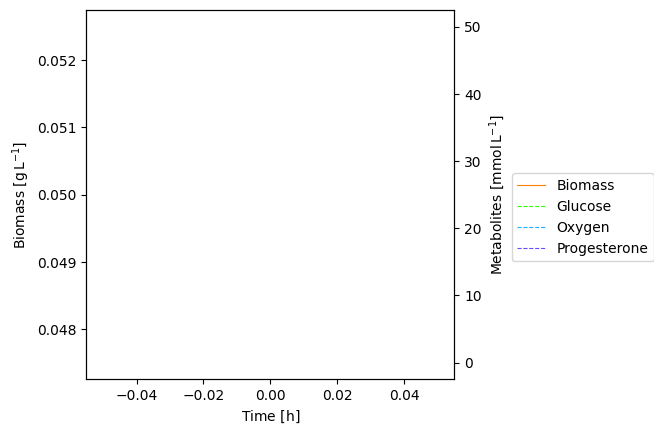

In [53]:
plot_concentrations(concentrations)
#plt.xlim([0, 10])
#plt.show()

In [54]:
concentrations

,time,Biomass,Glucose,Oxygen,Progesterone
0,0.0,0.05,50.0,5.0,0.0


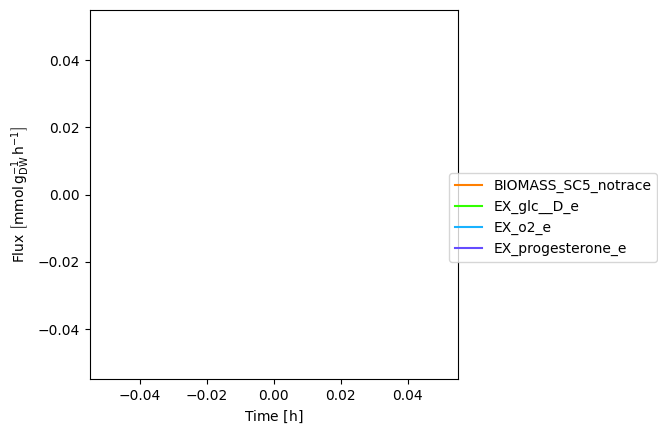

In [55]:
plot_trajectories(trajectories)